In [2]:
%matplotlib inline

import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt
import math

###
batch_size = 64
window_size = 192
encode_length = 168
decode_length = 24
hidden_unit = 10
'''
#Electricity
shift_train_data = np.load("../data/Electricity/elect_pre_train_data.npy")
shift_train_onehot = np.load("../data/Electricity/elect_train_onehot.npy")
v_all = np.load("../data/Electricity/elect_train_v.npy")
shift_train_label = np.load("../data/Electricity/elect_train_label.npy")
param = np.load("../data/Electricity/elect_train_param.npy")
index_list = np.load("../data/Electricity/elect_train_index.npy")
indexs_pred = np.load("../data/Electricity/elect_train_pred_index.npy")
'''
#huawei
shift_train_data = np.load("../data/huawei/shift_train_data.npy")
shift_train_onehot = np.load("../data/huawei/shift_train_onehot.npy")
v_all = np.load("../data/huawei/v.npy")
shift_train_label = np.load("../data/huawei/shift_train_label.npy")
param = np.load("../data/huawei/param.npy")
index_list = np.load("../data/huawei/indexs_list.npy")
indexs_pred_list = np.load("../data/huawei/indexs_pred_list.npy")
'''
#Fake Data
shift_train_data = np.load("../data/fake_data/elect_pre_train_data.npy")
shift_train_onehot = np.load("../data/fake_data/elect_train_onehot.npy")
v_all = np.load("../data/fake_data/elect_train_v.npy")
shift_train_label = np.load("../data/fake_data/elect_train_label.npy")
param = np.load("../data/fake_data/elect_train_param.npy")
index_list = np.load("../data/fake_data/elect_train_index.npy")
indexs_pred_list = np.load("../data/fake_data/elect_train_pred_index.npy")
'''
window_size = param[7]



/home/guest/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
def plot(label, label_f, prediction, sigma_test, prediction_f, sigma_test_f, window_size, num_plot = 8, 
            y_range = None, y_range_f = None, forget_gate=np.array([[-1],[-1]]), forget_gate_f=np.array([[-1],[-1]]), save_num=None):
    x = np.arange(192)
    pred_minus_sigma = prediction - sigma_test
    pred_minus_sigma_f = prediction_f - sigma_test_f
    pred_plus_sigma = prediction + sigma_test
    pred_plus_sigma_f = prediction_f + sigma_test_f
    f = plt.figure(figsize=(50,32))

    base_1 = num_plot/2
    base_2 = 2

    for i in range(int(num_plot/2)):

        label_temp = label[i].reshape([window_size,])
        label_temp_f = label_f[i].reshape([window_size,])
        pred_temp = prediction[i].reshape([window_size,])
        pred_temp_f = prediction_f[i].reshape([window_size,])
        if forget_gate[0,0]!=-1 :
            forget_gate_temp = forget_gate[i].reshape([window_size,])
        if forget_gate_f[0,0]!=-1 :
            forget_gate_temp_f = forget_gate_f[i].reshape([window_size,])
                
        # no forget_gate

        plt.subplot(base_1, base_2, i*2+1)
        labels, = plt.plot(x,label_temp, color='b')
        preds, = plt.plot(x,pred_temp, color='r')
        stddev = plt.fill_between(x, pred_minus_sigma[i].reshape([window_size,]) ,
                                 pred_plus_sigma[i].reshape([window_size,])  ,
                                 color='blue',
                                 alpha=0.2)
        if forget_gate[0,0]!=-1 :
            forget_gates, = plt.plot(x, forget_gate_temp, color='g')
            plt.legend(handles = [labels, preds, stddev, forget_gates], labels = ['Ground_truth', 'Prediction', 'Single stddev ', 'forget_gate'], loc = 'upper left', fontsize =12)
        else:
            plt.legend(handles = [labels, preds, stddev], labels = ['Ground_truth', 'Prediction', 'Single stddev '], loc = 'upper left', fontsize =12)
        plt.axvline(168, color='k', linestyle = "dashed")
        #参考线
        ax = plt.gca()
        ax.tick_params(axis = 'x', which = 'major', labelsize = 24)
        ax.tick_params(axis = 'y', which = 'major', labelsize = 24)
        axes = plt.gca()
        if y_range:  axes.set_ylim(y_range)

        # forget_gate

        plt.subplot(base_1, base_2, i*2+2)
        labels, = plt.plot(x,label_temp_f, color='b')
        preds, = plt.plot(x,pred_temp_f, color='r')
        stddev_f = plt.fill_between(x, pred_minus_sigma_f[i].reshape([window_size,]) ,
                                 pred_plus_sigma_f[i].reshape([window_size,])  ,
                                 color='blue',
                                 alpha=0.2)
        if forget_gate_f[0,0]!=-1:
            forget_gates, = plt.plot(x, forget_gate_temp_f, color='g')
            plt.legend(handles = [labels, preds, stddev_f, forget_gates], labels = ['Ground_truth', 'Prediction', 'Single stddev ', 'forget_gate'], loc = 'upper left', fontsize =12)
        else:
            plt.legend(handles = [labels, preds, stddev_f], labels = ['Ground_truth', 'Prediction', 'Single stddev '], loc = 'upper left', fontsize =12)
        plt.axvline(168, color='k', linestyle = "dashed")
        #参考线
        ax = plt.gca()
        ax.tick_params(axis = 'x', which = 'major', labelsize = 24)
        ax.tick_params(axis = 'y', which = 'major', labelsize = 24)
        axes = plt.gca()
        if y_range:  axes.set_ylim(y_range_f)
        if save_num: f.savefig(str(save_num)+".png")

def compute_new_v(values):
    v = np.mean(values)+1
    return v
    
def rescale(values, v_old, v_new):
    values_temp = values*v_old
    return np.true_divide(values_temp, v_new)

def compute_forget_index(p_values): 
    #compute the index of the last change point
    index_list = []
    for serie in range(p_values.shape[0]):
        for i in reversed(range(p_values.shape[1])): #from 191 to 0
            if p_values[serie,i,0]==0: 
                index_list.append(i)
                break
            elif i==0:
                index_list.append(-1)
    index = np.array(index_list)
    return index #shape = [64,]
                
def compute_hidden_states_relation(serie, i): #serie.shape: [window_size, hidden_unit]
    if i==0 or i==window_size-1:
        return 0
    dot_product_temp = np.dot(serie[i], serie[i+1])
    #dot_product_temp = np.mean(serie[i])
    return dot_product_temp

              
def compute_forget_gate_relation(serie, i): #serie.shape: [window_size, hidden_unit]
    if i==0 or i==window_size-1:
        return 0
    #dot_product_temp = np.dot(serie[i], serie[i+1])
    dot_product_temp = np.linalg.norm(serie[i])
    return dot_product_temp


def norm(value):
    mean = np.mean(value)
    if mean !=0:
        return value/mean
    else:
        return value



In [5]:
# compute ND and RMSE
def RMSE_compute(mu, label, std, encode_length, decode_length, window_size):
    mu_pred = mu[:, encode_length:window_size]
    label_pred = label[:, encode_length:window_size]
    std_pred = std[:, encode_length:window_size]
    
    RMSE = np.square((label_pred - mu_pred))
    norm = np.absolute(label_pred)
    norm = np.mean(norm)
    norm_pred = np.absolute(mu_pred)
    norm_pred = np.mean(norm_pred)
    
    #two sigma
    mask_under_10 = label_pred<=10
    mask = np.logical_and((mu_pred-2*std_pred)<label_pred, label_pred<(mu_pred+2*std_pred))
    mask = np.logical_and(mask, mask_under_10)
    mask = mask.astype(int)
    mask = np.absolute(mask-1) #invert
    RMSE = RMSE * mask
    #print (mask)
    
    RMSE = np.sqrt(np.mean(RMSE))
    if norm!=0:
        RMSE_norm = RMSE/norm
        return RMSE_norm
    else:
        if RMSE==0:
            return 0
        else:
            RMSE_norm = RMSE/((norm_pred+norm)/2.0)
            return RMSE_norm

def ND_compute(index_pred_number, mu, label,std, encode_length, decode_length, window_size):
    mu_pred = mu[:, encode_length:window_size] 
    label_pred = label[:, encode_length:window_size]
    std_pred = std[:, encode_length:window_size]
    sum_subtract = np.absolute((mu_pred-label_pred))
    
    #two sigma
    mask_under_10 = label_pred<=10
    mask = np.logical_and((mu_pred-2*std_pred)<=label_pred, label_pred<=(mu_pred+2*std_pred))
    mask = np.logical_and(mask, mask_under_10)
    mask = mask.astype(int)
    mask = np.abs(mask-1) #invert
    sum_subtract = sum_subtract * mask
    ND_list = []
    
    for i in range(sum_subtract.shape[0]): #compute ND for each series and then compute the average
        sum_subtract_temp = np.sum(sum_subtract[i])
        sum_label_temp = np.sum(np.abs(label_pred[i]))
        sum_pred_temp = np.sum(np.abs(mu_pred[i]))
        if sum_label_temp!=0:
            #ND_temp = sum_subtract_temp/sum_label_temp
            ND_temp =  sum_subtract_temp/((sum_label_temp+sum_pred_temp)/2.0)
        else:
            if sum_subtract_temp==0:
                ND_temp = 0
            else:
                print("nd!=0 but sum_label==0")
                ND_temp =  sum_subtract_temp/((sum_label_temp+sum_pred_temp)/2.0)
        
        if (ND_temp>20):
            print ("index_pred_number: ", index_pred_number)
            print ("index_number: ", i )
            print ("real index: ", indexs_pred_list[index_pred_number, i])
            print ("ND of this serie is HIGH", ND_temp)
            print (sum_subtract_temp)
            print (sum_label_temp)
            print (sum_pred_temp)
            print ("*************************")
            ND_temp=0.25
        ND_list.append(ND_temp)
            
        
    ND = np.mean(np.array(ND_list))
    
    return ND

with tf.Session() as sess:
    #FORGET
    #checkpoint_dir = "../checkpoint/checkpoint_forget/"
    
    #CNN
    #checkpoint_dir = "../checkpoint/checkpoint_CNN/"
    
    #CNN-huawei-v
    checkpoint_dir = "../checkpoint/checkpoint_CNN_Fuahui_v_40/"
    
    
    #ckpt包含所有checkpoint信息和最新checkpoint信息
    ckpt = tf.train.get_checkpoint_state(checkpoint_dir)
    print(ckpt)
    # ckpt.model_checkpoint_path是最新checkpoint的名字，加上".meta"即可用于导入graph
    if (ckpt and ckpt.model_checkpoint_path):
        #加载计算图
        saver = tf.train.import_meta_graph(ckpt.model_checkpoint_path+".meta")
        #加载参数
        saver.restore(sess, ckpt.model_checkpoint_path)


    else:
        print("No model can be load!")

    train_op = tf.get_collection('train_op')[0]
    label = tf.get_collection("label")[0]

    miu_train = tf.get_collection("miu_train")[0]
    sigma_train = tf.get_collection("sigma_train")[0]
    RMSE_train = tf.get_collection("RMSE_train")[0]
    ND_train = tf.get_collection("ND_train")[0]

    miu_pred = tf.get_collection("miu_pred")[0]
    sigma_pred = tf.get_collection("sigma_pred")[0]
    RMSE_pred = tf.get_collection("RMSE_pred")[0]
    ND_pred = tf.get_collection("ND_pred")[0]
    hidden_states_all = tf.get_collection("hidden_states_all")[0] # shape: [2, batch_size, hidden_unit, window_size] = [2, 64, 40, 192]
    forget_gate_all = tf.get_collection("CNN_output")[0] #shape: [batch_size, window_size=192, hidden_unit=40]


    def test_step(x_batch, onehot_batch, y_batch, v_batch, batch_size, keep_prob, forget_gate_mask):
        feed_dict ={
        'input_x:0': x_batch, 
        'input_onehot:0': onehot_batch,
        'input_y:0': y_batch,
        'input_v:0' :v_batch,
        #'input_mean:0':mean_batch,
        'input_batch:0': batch_size,
        'keep_prob:0': keep_prob,
        "forget_gate_mask:0": forget_gate_mask,
        }
        #RMSE_test, ND_test, miu_test, sigma_test, hidden_states_all_test, = sess.run([RMSE_pred,
        RMSE_test, ND_test, miu_test, sigma_test, hidden_states_all_test, forget_gate_all_test = sess.run([RMSE_pred,
                                                            ND_pred,
                                                            miu_pred,
                                                            sigma_pred,
                                                            hidden_states_all,                      
                                                            forget_gate_all,
                                                            ], feed_dict = feed_dict)
        

        
        #return (RMSE_test, ND_test, miu_test, sigma_test, hidden_states_all_test)
        return (RMSE_test, ND_test, miu_test, sigma_test, hidden_states_all_test, forget_gate_all_test)
    
    #indexs_pred = [410688, 324890, 81043, 269732, 382203, 421931, 363429, 517402]
    #indexs_pred = [i+1058 for i in range(64)]
    #indexs_pred = [i*1375 for i in range(64)]
    #indexs_pred = [i+41992 for i in range(64)]
    print ("indexs_pred_list.shape: ", indexs_pred_list.shape)
    RMSE=0
    ND=0
    for i, index_pred in enumerate(indexs_pred_list):
        input_x_batch_pred = shift_train_data[index_pred]
        input_onehot_batch_pred =shift_train_onehot[index_pred]
        #input_onehot_batch_pred =shift_train_onehot
        input_v_batch_pred = v_all[index_pred]
        #input_mean_batch_pred = mean_all[index_pred]
        input_y_batch_pred = shift_train_label[index_pred]
        input_y_batch_pred = np.asfarray(input_y_batch_pred, float)
        batch_size_pred = len(index_pred)
        forget_gate_mask_sample = np.full((64, 192, 40), 1, dtype = np.float32) #all 1

        RMSE_test, ND_test, miu_test, sigma_test, hidden_states_all_test, forget_gate_all_test = test_step(x_batch = input_x_batch_pred, 
        #RMSE_test, ND_test, miu_test, sigma_test, hidden_states_all_test = test_step(x_batch = input_x_batch_pred, 
                                                            onehot_batch = input_onehot_batch_pred, 
                                                            y_batch = input_y_batch_pred, 
                                                            v_batch = input_v_batch_pred, 
                                                            #mean_batch = input_mean_batch_pred, 
                                                            batch_size = batch_size_pred,
                                                            keep_prob = 1.0, 
                                                            #forget_gate_mask = forget_gate_mask_sample, 
                                                            forget_gate_mask = forget_gate_mask_sample, 
                                                            )
        
        RMSE_test = RMSE_compute(miu_test, input_y_batch_pred ,sigma_test, encode_length, decode_length, window_size)
        ND_test = ND_compute(i, miu_test, input_y_batch_pred ,sigma_test, encode_length, decode_length, window_size)
        RMSE += RMSE_test
        ND += ND_test
        
        #print (RMSE_test)
        #print (ND_test)
        #print ("***")
    RMSE /= indexs_pred_list.shape[0]
    ND /= indexs_pred_list.shape[0]
    print ("RMSE: ", RMSE)
    print ("ND: ", ND)



model_checkpoint_path: "../checkpoint/checkpoint_CNN_Fuahui_v_40/DeepAR_model-156000"
all_model_checkpoint_paths: "../checkpoint/checkpoint_CNN_Fuahui_v_40/DeepAR_model-148000"
all_model_checkpoint_paths: "../checkpoint/checkpoint_CNN_Fuahui_v_40/DeepAR_model-150000"
all_model_checkpoint_paths: "../checkpoint/checkpoint_CNN_Fuahui_v_40/DeepAR_model-152000"
all_model_checkpoint_paths: "../checkpoint/checkpoint_CNN_Fuahui_v_40/DeepAR_model-154000"
all_model_checkpoint_paths: "../checkpoint/checkpoint_CNN_Fuahui_v_40/DeepAR_model-156000"

INFO:tensorflow:Restoring parameters from ../checkpoint/checkpoint_CNN_Fuahui_v_40/DeepAR_model-156000
indexs_pred_list.shape:  (955, 64)
nd!=0 but sum_label==0
index_pred_number:  27
index_number:  18
real index:  493430
ND of this serie is HIGH 41.18080444335938
823.6160888671875
20.0
2646.0615
*************************
nd!=0 but sum_label==0
index_pred_number:  50
index_number:  2
real index:  247267
ND of this serie is HIGH 34.270893525104135
16792.7

model_checkpoint_path: "../checkpoint/checkpoint_CNN_Fuahui_v_40/DeepAR_model-156000"
all_model_checkpoint_paths: "../checkpoint/checkpoint_CNN_Fuahui_v_40/DeepAR_model-148000"
all_model_checkpoint_paths: "../checkpoint/checkpoint_CNN_Fuahui_v_40/DeepAR_model-150000"
all_model_checkpoint_paths: "../checkpoint/checkpoint_CNN_Fuahui_v_40/DeepAR_model-152000"
all_model_checkpoint_paths: "../checkpoint/checkpoint_CNN_Fuahui_v_40/DeepAR_model-154000"
all_model_checkpoint_paths: "../checkpoint/checkpoint_CNN_Fuahui_v_40/DeepAR_model-156000"

INFO:tensorflow:Restoring parameters from ../checkpoint/checkpoint_CNN_Fuahui_v_40/DeepAR_model-156000
hidden_states_all_test.shape:  (3, 2, 64, 40, 192)
hidden_states_c.shape:  (64, 192, 40)
************************************************************************************


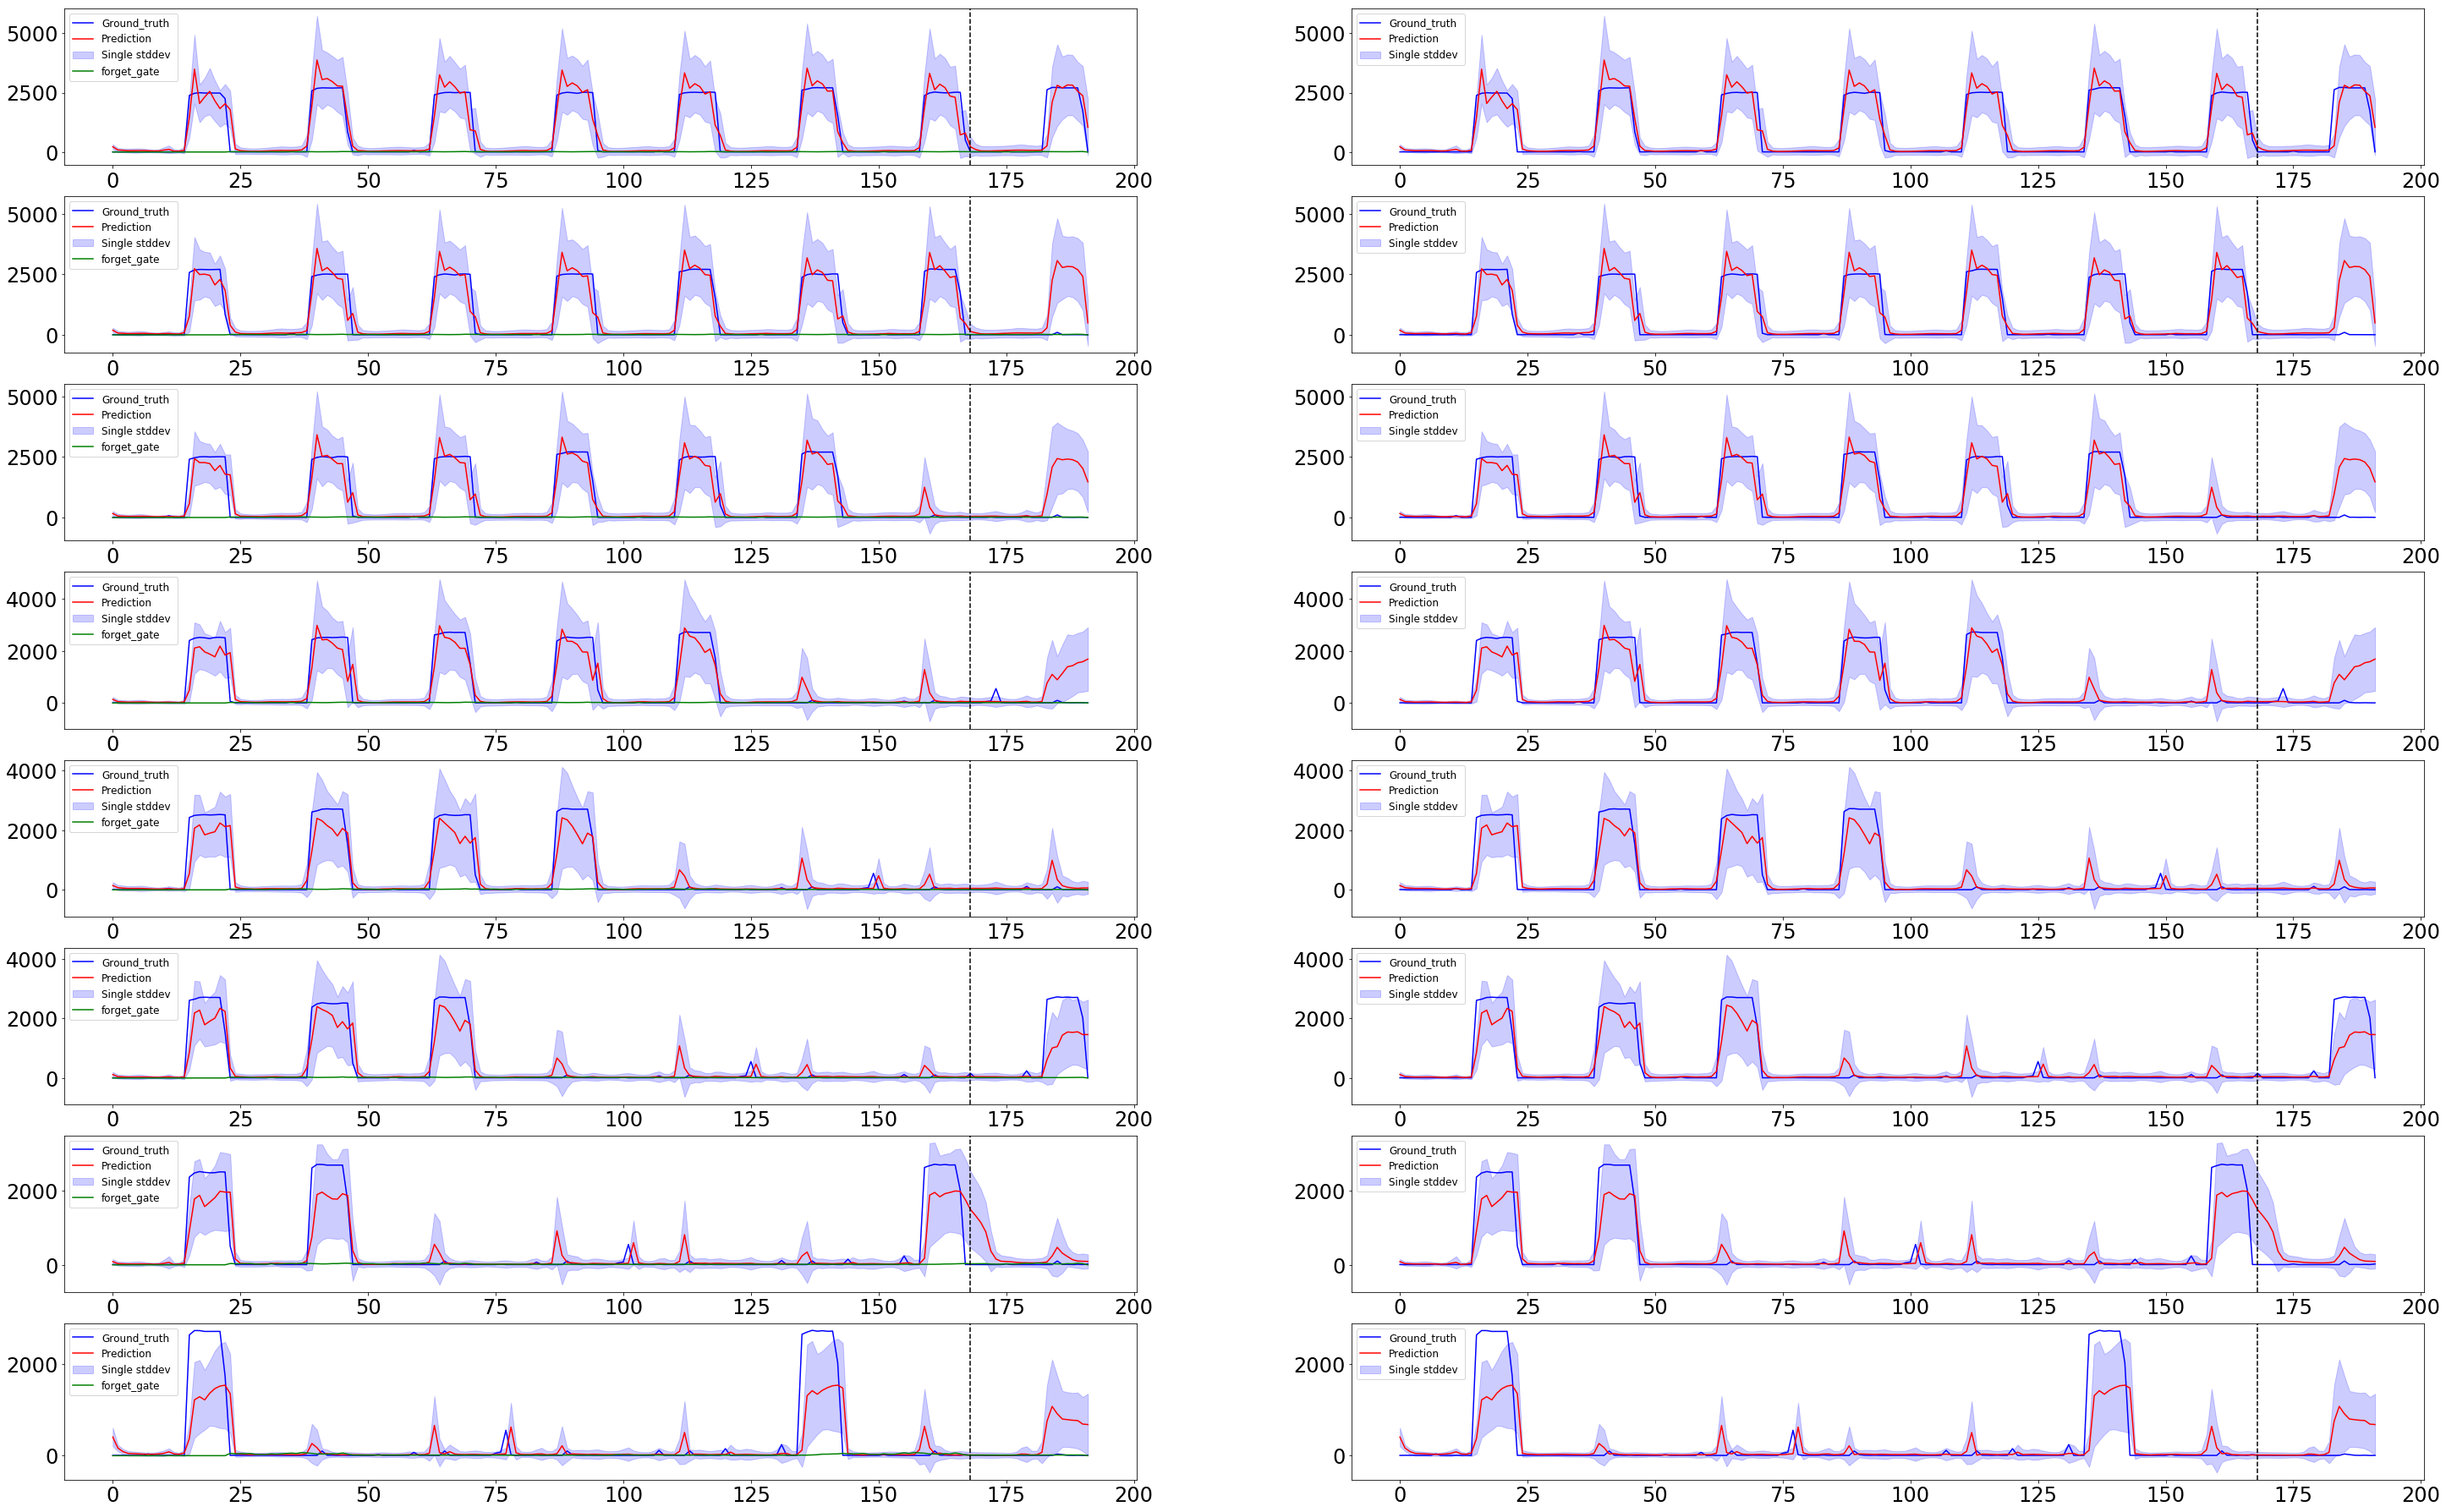

In [4]:
with tf.Session() as sess:
    #FORGET
    #checkpoint_dir = "../checkpoint/checkpoint_forget/"
    
    #CNN
    #checkpoint_dir = "../checkpoint/checkpoint_CNN/"
    
    #CNN-huawei-v
    checkpoint_dir = "../checkpoint/checkpoint_CNN_Fuahui_v_40/"
    
    
    #ckpt包含所有checkpoint信息和最新checkpoint信息
    ckpt = tf.train.get_checkpoint_state(checkpoint_dir)
    print(ckpt)
    # ckpt.model_checkpoint_path是最新checkpoint的名字，加上".meta"即可用于导入graph
    if (ckpt and ckpt.model_checkpoint_path):
        #加载计算图
        saver = tf.train.import_meta_graph(ckpt.model_checkpoint_path+".meta")
        #加载参数
        saver.restore(sess, ckpt.model_checkpoint_path)


    else:
        print("No model can be load!")

    train_op = tf.get_collection('train_op')[0]
    label = tf.get_collection("label")[0]

    miu_train = tf.get_collection("miu_train")[0]
    sigma_train = tf.get_collection("sigma_train")[0]
    RMSE_train = tf.get_collection("RMSE_train")[0]
    ND_train = tf.get_collection("ND_train")[0]

    miu_pred = tf.get_collection("miu_pred")[0]
    sigma_pred = tf.get_collection("sigma_pred")[0]
    RMSE_pred = tf.get_collection("RMSE_pred")[0]
    ND_pred = tf.get_collection("ND_pred")[0]
    hidden_states_all = tf.get_collection("hidden_states_all")[0] # shape: [2, batch_size, hidden_unit, window_size] = [2, 64, 40, 192]
    forget_gate_all = tf.get_collection("CNN_output")[0] #shape: [batch_size, window_size=192, hidden_unit=40]


    def test_step(x_batch, onehot_batch, y_batch, v_batch, batch_size, keep_prob, forget_gate_mask):
        feed_dict ={
        'input_x:0': x_batch, 
        'input_onehot:0': onehot_batch,
        'input_y:0': y_batch,
        'input_v:0' :v_batch,
        #'input_mean:0':mean_batch,
        'input_batch:0': batch_size,
        'keep_prob:0': keep_prob,
        "forget_gate_mask:0": forget_gate_mask,
        }
        #RMSE_test, ND_test, miu_test, sigma_test, hidden_states_all_test, = sess.run([RMSE_pred,
        RMSE_test, ND_test, miu_test, sigma_test, hidden_states_all_test, forget_gate_all_test = sess.run([RMSE_pred,
                                                            ND_pred,
                                                            miu_pred,
                                                            sigma_pred,
                                                            hidden_states_all,                      
                                                            forget_gate_all,
                                                            ], feed_dict = feed_dict)
        

        
        #return (RMSE_test, ND_test, miu_test, sigma_test, hidden_states_all_test)
        return (RMSE_test, ND_test, miu_test, sigma_test, hidden_states_all_test, forget_gate_all_test)
    
    #indexs_pred = [410688, 324890, 81043, 269732, 382203, 421931, 363429, 517402]
    #indexs_pred = [i+1058 for i in range(64)]
    #indexs_pred = [i for i in range(64)]
    #indexs_pred = [i+41992 for i in range(64)]
    indexs_pred = [i+39810 for i in range(64)]
    
    
    input_x_batch_pred = shift_train_data[indexs_pred]
    input_onehot_batch_pred =shift_train_onehot[indexs_pred]
    #input_onehot_batch_pred =shift_train_onehot
    input_v_batch_pred = v_all[indexs_pred]
    #input_mean_batch_pred = mean_all[indexs_pred]
    input_y_batch_pred = shift_train_label[indexs_pred]
    input_y_batch_pred = np.asfarray(input_y_batch_pred, float)
    batch_size_pred = len(indexs_pred)
    '''
    shift_train_pvalue = np.load("../data/Electricity/elect_train_p_value.npy") #[num_window_all, window_size] last 24 p are strictly 0
    shift_train_pvalue_raw = np.copy(shift_train_pvalue) #[num_window_all, window_size]
    shift_train_pvalue = np.abs(shift_train_pvalue-1) #shift 0&1
    shift_train_pvalue_raw = shift_train_pvalue_raw[indexs_pred]
    input_pvalue_batch_pred = shift_train_pvalue[indexs_pred] #[batch_size, window_size]
    input_pvalue_batch_pred_2d = np.copy(input_pvalue_batch_pred)
    input_pvalue_batch_pred = np.concatenate([np.expand_dims(input_pvalue_batch_pred, axis=2) for i in range(40)], axis=2) #[batch_size, window_size, 40]
    '''
    forget_gate_mask_sample = np.full((64, 192, 40), 1, dtype = np.float32) #all 1

    RMSE_test, ND_test, miu_test, sigma_test, hidden_states_all_test, forget_gate_all_test = test_step(x_batch = input_x_batch_pred, 
    #RMSE_test, ND_test, miu_test, sigma_test, hidden_states_all_test = test_step(x_batch = input_x_batch_pred, 
                                                        onehot_batch = input_onehot_batch_pred, 
                                                        y_batch = input_y_batch_pred, 
                                                        v_batch = input_v_batch_pred, 
                                                        #mean_batch = input_mean_batch_pred, 
                                                        batch_size = batch_size_pred,
                                                        keep_prob = 1.0, 
                                                        #forget_gate_mask = forget_gate_mask_sample, 
                                                        forget_gate_mask = forget_gate_mask_sample, 
                                                        )
    
    ### hidden states ### shape:  [3, 2, 64, 40, 192] or [2, 64, 40, 192]
    print ("hidden_states_all_test.shape: ", hidden_states_all_test.shape)
    if  len(hidden_states_all_test.shape) == 5:
        hidden_states_c = hidden_states_all_test[0, 0, :, :, :] 
    elif len(hidden_states_all_test.shape) == 4:
        hidden_states_c = hidden_states_all_test[0, :, :, :] 
    else:
        print ("hidden_states shape not compatible")
    hidden_states_c = np.swapaxes(hidden_states_c, -1, -2) # [batch_size, window_size, hidden_unit]
    print ("hidden_states_c.shape: ", hidden_states_c.shape)
    hidden_states_dot = []
    forget_gate_dot = []
    for serie in range(batch_size):
        hidden_states_dot_serie = []
        forget_gate_dot_serie = []
        for i in range(window_size):
            hidden_states_dot_temp = compute_hidden_states_relation(hidden_states_c[serie, :, :], i)
            hidden_states_dot_serie.append(hidden_states_dot_temp)
            forget_gate_dot_temp = compute_forget_gate_relation(forget_gate_all_test[serie, :, :], i)
            forget_gate_dot_serie.append(forget_gate_dot_temp)
        hidden_states_dot.append(hidden_states_dot_serie)
        forget_gate_dot.append(forget_gate_dot_serie)
    hidden_states_dot = np.array(hidden_states_dot)#[64, 192]
    hidden_states_dot = norm(hidden_states_dot)
    forget_gate_dot = np.array(forget_gate_dot)
    forget_gate_dot = norm(forget_gate_dot)
    print ("************************************************************************************")
    
    input_y_batch_pred_copy = np.copy(input_y_batch_pred)
    miu_test_copy = miu_test
    sigma_test_copy = sigma_test
    
    ## WITH FORGET
    # rescale values after the last change point
    '''
    forget_index = compute_forget_index(input_pvalue_batch_pred) #[64,]
    new_v = []
    for serie in range(64):
        if forget_index[serie] != -1:
            index_temp = forget_index[serie]
            input_x_batch_pred_new = input_x_batch_pred[serie, index_temp+1:, 0] 
            #print (input_x_batch_pred_new.shape) #[length_after_change,]
            input_v_new = compute_new_v(input_x_batch_pred_new*input_v_batch_pred[serie])
            new_v.append(input_v_new)
            input_x_batch_pred_new = rescale(input_x_batch_pred_new, 
                                             v_old=input_v_batch_pred[serie], 
                                             v_new=input_v_new, )
            input_x_batch_pred[serie, index_temp+1:, 0] = input_x_batch_pred_new
        else:
            new_v.append(input_v_batch_pred[serie])   
    #print (new_v)
    #print (input_v_batch_pred)
    new_v = np.array(new_v)
    new_v = np.expand_dims(new_v, axis=1) #[batch_size, 1]
    '''
    
    RMSE_test_f, ND_test_f, miu_test_f, sigma_test_f, hidden_states_all_test_f, forget_gate_all_test_f = test_step(x_batch = input_x_batch_pred,     
    #RMSE_test_f, ND_test_f, miu_test_f, sigma_test_f, hidden_states_all_test_f  = test_step(x_batch = input_x_batch_pred, 
                                                        onehot_batch = input_onehot_batch_pred, 
                                                        y_batch = input_y_batch_pred, 
                                                        #v_batch = new_v, 
                                                        v_batch = input_v_batch_pred, 
                                                        #mean_batch = input_mean_batch_pred, 
                                                        batch_size = batch_size_pred,
                                                        keep_prob = 1.0,                                                                                            
                                                        forget_gate_mask = forget_gate_mask_sample, 
                                                        )
    
    #miu_test_f  = np.true_divide(miu_test_f, new_v)
    #sigma_test_f  = np.true_divide(sigma_test_f, np.sqrt(new_v))
    #forget_gate_all_test_f = mean(forget_gate_all_test_f, axis=2) #[batch_size, window_length]

    
    
    
    
    
    plot(label = input_y_batch_pred, 
             label_f = input_y_batch_pred_copy,
             prediction = miu_test,
             sigma_test = sigma_test,
             prediction_f =miu_test_f , 
             sigma_test_f = sigma_test_f, 
             window_size = 192, 
             num_plot = 16,
             #y_range = [-2, 5],
             #y_range_f = [-2, 60],
             forget_gate = forget_gate_dot*15, 
             #forget_gate_f=forget_gate_dot,
             save_num = None,
             #save_num = 'DeepAR',
                )

